In [2]:
using LowRankModels, Plots, Random, SparseArrays, DataFrames

LowRankModels.jl is a julia package for modeling and fitting generalized low rank models (GLRMs). GLRMs model a data array by a low rank matrix, and include many well known models in data analysis, such as principal components analysis (PCA), matrix completion, robust PCA, nonnegative matrix factorization, k-means, and many more.

LowRankModels.jl makes it easy to mix and match loss functions and regularizers to construct a model suitable for a particular data set. In particular, it supports

   * using different loss functions for different columns of the data array, which is useful when data types are heterogeneous (eg, real, boolean, and ordinal columns);
   * fitting the model to only some of the entries in the table, which is useful for data tables with many missing (unobserved) entries; and
   * adding offsets and scalings to the model without destroying sparsity, which is useful when the data is poorly scaled.


# Losses

A wide variety of loss functions are available in LowRankModels:

* quadratic loss `QuadLoss`
* hinge loss `HingeLoss`
* logistic loss `LogisticLoss`
* poisson loss `PoissonLoss`
* weighted hinge loss `WeightedHingeLoss`
* l1 loss `L1Loss`
* ordinal hinge loss `OrdinalHingeLoss`
* periodic loss `PeriodicLoss`
* multinomial categorical loss `MultinomialLoss`
* multinomial ordinal (aka ordered logit) loss `OrderedMultinomialLoss`
* bigger-vs-smaller loss `BvSLoss` (for ordinal data)
* one-vs all-loss `OvALoss` (for categorical data)

In [30]:
# example loss function
loss = QuadLoss()

QuadLoss(1.0, RealDomain())

In [31]:
evaluate(loss,2.,4.) # (2-4)^2

4.0

In [32]:
evaluate(loss,1.,2.) # (1-2)^2

1.0

# Regularizers

Regularizers help ensure a more interpretable model, eg, one with nonnegative coefficients. Quadratic regularization helps stabilize the fitting procedure.

   * quadratic regularization - QuadReg()
   * constrained squared euclidean norm - QuadConstraint()
   * l1 regularization - OneReg()
   * no regularization - ZeroReg()
   * nonnegative constraint - NonNegConstraint() (eg, for nonnegative matrix factorization)
   * 1-sparse constraint - OneSparseConstraint() (eg, for orthogonal NNMF)
   * unit 1-sparse constraint - UnitOneSparseConstraint() (eg, for k-means)
   * simplex constraint - SimplexConstraint()
   * l1 regularization, combined with nonnegative constraint - NonNegOneReg()
   * fix features at values y0 - FixedLatentFeaturesConstraint(y0)

In [33]:
# regularizers
nonneg = NonNegConstraint()  # convex indicator of the nonnegative orthant
l2 = QuadReg(5)              # 5(.)^2

QuadReg(5.0)

In [34]:
evaluate(nonneg, 1)

0

In [35]:
evaluate(nonneg, -1)

Inf

In [36]:
evaluate(l2, 1) # 5(1)^2

5.0

In [37]:
evaluate(l2, -2) # 5(-2)^2

20.0

# Generalized Low Rank Models

GLRMs form a low rank model for tabular data A with m rows and n columns, which can be input as an array or any array-like object (for example, a data frame). It is fine if only some of the entries have been observed (i.e., the others are missing or NA); the GLRM will only be fit on the observed entries $\Omega$.

The desired model is specified by choosing a rank k for the model, an array of loss functions losses, and two regularizers, $r_x$ and $r_w$. The data is modeled as $X^TY$, where $X$ is a $k\times m$ matrix and $Y$ is a $k\times n$ matrix. $X$ and $Y$ are found by solving the optimization problem

$$\min \sum_{(i,j) \in \Omega} \ell_j\bigg((X^T Y)[i,j], A[i,j]\bigg) + \sum_i r_x(X[:,i]) + \sum_j r_y(Y[:,j])$$

To form a GLRM, the user specifies

   * the data $A$ (any AbstractArray, such as an array, a sparse matrix, or a data frame)
   * the array of loss functions $\ell$
   * the regularizers $r_x$ and $r_w$
   * the rank $k$
   * the observations $\Omega$


## Example: dense matrix, incomplete observations

In [38]:
Random.seed!(1)

# generate data
m,n = 20,10
A = rand(m,2)*rand(2,n)          # data matrix 

# look for a nonnegative factorization with rank 5
loss = QuadLoss()           # quadratic loss
nonneg = NonNegConstraint() # require nonnegative factors
k = 5
Ω = [(rand(1:m), rand(1:n)) for iobs in 1:100] # observe 50 random entries, with replacement
glrm = GLRM(A, loss, nonneg, nonneg, k, obs=Ω);

In [39]:
# To fit the model, call
X,Y,ch = fit!(glrm);

Fitting GLRM
Iteration 10: objective value = 30.96601471516671
Iteration 20: objective value = 25.906874109924694
Iteration 30: objective value = 21.032954794013904
Iteration 40: objective value = 18.652747843346216
Iteration 50: objective value = 17.555095496418712
Iteration 60: objective value = 17.040150781258383
Iteration 70: objective value = 16.676535553975437
Iteration 80: objective value = 16.36043529444562
Iteration 90: objective value = 16.04190265061905
Iteration 100: objective value = 15.739454018044162


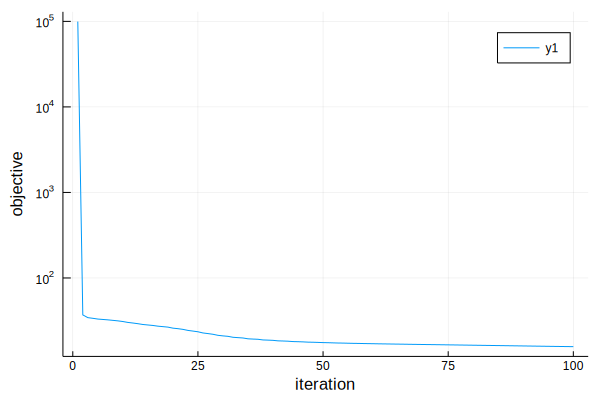

In [40]:
# did it converge? 
plot(ch.objective[2:end])  # first entry is infinite, since initial factors are not nonnegative
xlabel!("iteration")
ylabel!("objective")
yaxis!(:log)

This runs an alternating directions proximal gradient method to find the $X$ and $Y$ that minimize the objective function.

In [41]:
X

5×20 Array{Float64,2}:
 0.0869609  0.133926    0.12529   0.0  …  0.0  0.0  0.113651    0.395263  
 0.0        0.0853408   0.125362  0.0     0.0  0.0  0.00705357  0.0       
 0.0        0.0434652   0.0       0.0     0.0  0.0  0.0267825   0.00186851
 0.0        0.136009    0.0       0.0     0.0  0.0  0.0180746   0.0       
 0.0        0.00343981  0.0       0.0     0.0  0.0  0.0513907   2.8092e-5 

In [42]:
Y

5×10 Array{Float64,2}:
 2.11424    2.0145      0.689844     …  1.03779   0.491886  0.657266
 2.93206    2.26443     0.623894        1.19131   3.23841   1.88255 
 0.0629576  0.00173739  0.00235652      2.90583   2.24857   6.0587  
 0.185631   0.210268    0.000980211     0.0       1.87045   2.61232 
 0.130496   0.21822     0.000739932     0.232767  2.49313   0.19638 

To find a better approximation, try restarting the iteration (if you see convergence), or running for more iterations. 
You can just call fit!(glrm) again, or increase the number of iterations.

# Initialization

You'll also often improve convergence, or even converge to a better solution, with good initialization:

In [43]:
init_svd!(glrm)
X,Y,ch_svd = fit!(glrm)

Fitting GLRM
Iteration 10: objective value = 0.13447604673539088
Iteration 20: objective value = 0.038027469752441506
Iteration 30: objective value = 0.01086888732733188


([0.141087 0.0 … 0.098328 0.271028; 0.255692 0.133129 … 0.292917 0.664573; … ; 0.335368 0.190858 … 0.192675 0.592641; 0.0 0.637137 … 0.100574 0.440502], [0.000547056 0.155107 … 0.0 0.0687331; 0.0670834 0.203036 … 0.134343 0.226194; … ; 0.512137 0.259018 … 0.0 0.50565; 0.529552 0.229209 … 0.224521 0.124723], ConvergenceHistory("ProxGradGLRM", [Inf, 28.4395, 9.14371, 0.864888, 0.37692, 0.272977, 0.221574, 0.193896, 0.17122, 0.151837  …  0.0289067, 0.0249007, 0.0217853, 0.0190616, 0.0170927, 0.0154683, 0.0137965, 0.0120712, 0.0108689, 0.00989485], Float64[], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.000282049, 0.00049305, 0.000689983, 0.000929117, 0.00114703, 0.00134301, 0.00154424, 0.00173616, 0.00192928  …  0.0046823, 0.00487542, 0.00511837, 0.00533319, 0.00558519, 0.00584412, 0.006212, 0.0064621, 0.00683403, 0.00

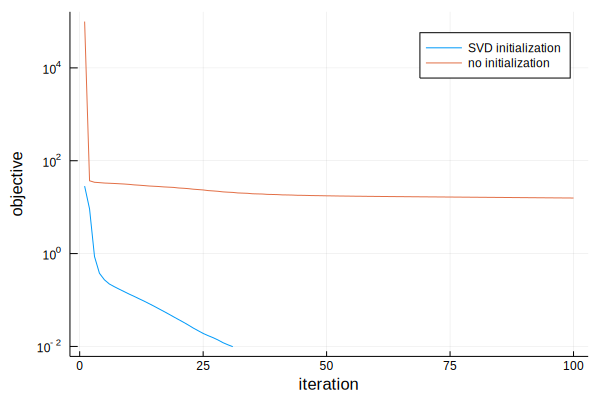

In [44]:
plot(ch_svd.objective[2:end], label="SVD initialization")
plot!(ch.objective[2:end], label="no initialization")
xlabel!("iteration")
ylabel!("objective")
yaxis!(:log)

## Imputation

In [45]:
impute(glrm)

20×10 Array{Number,2}:
 0.201064  0.178928  0.0936361  0.338963  …  0.0610706  0.0345337  0.255634
 0.626425  0.498201  0.404066   0.52571      0.35284    0.163703   0.485699
 0.889128  0.565398  0.590757   0.727527     0.501572   0.273879   0.524708
 0.264933  0.213167  0.172958   0.30727      0.140076   0.0812656  0.20812 
 0.849472  0.627437  0.40914    0.780748     0.346765   0.113373   0.797801
 0.488824  0.434675  0.350332   0.670804  …  0.271115   0.174788   0.472898
 0.620052  0.641855  0.322417   0.565983     0.29541    0.0685478  0.72269 
 1.1255    1.02346   0.63119    1.2256       0.527708   0.210468   1.20615 
 0.214933  0.198515  0.102426   0.335253     0.0716396  0.0341962  0.2766  
 0.79803   0.865126  0.424412   0.781505     0.385092   0.0947092  0.968798
 0.612195  0.538832  0.363826   0.736084  …  0.292544   0.14433    0.624619
 0.325503  0.351202  0.185431   0.469194     0.148028   0.0699904  0.372757
 0.371371  0.326883  0.187448   0.429956     0.152637   0.0570415

In [46]:
impute_missing(glrm)

20×10 Array{Number,2}:
 0.201064  0.185054  0.0820168  0.338963  …  0.0624565  0.0265428  0.255634
 0.626425  0.491632  0.404066   0.52571      0.365782   0.163703   0.485699
 0.897099  0.566953  0.588903   0.731374     0.483725   0.269266   0.524708
 0.264933  0.213167  0.172958   0.30727      0.140076   0.0846287  0.20812 
 0.853059  0.629974  0.40914    0.780748     0.346765   0.113373   0.791464
 0.488824  0.434675  0.350332   0.670804  …  0.271115   0.198513   0.472898
 0.620052  0.64935   0.322417   0.565983     0.29541    0.0685478  0.715202
 1.12935   1.00172   0.63119    1.2256       0.535958   0.210468   1.20846 
 0.214933  0.198804  0.102426   0.335253     0.0684571  0.0293892  0.2766  
 0.79803   0.870121  0.424412   0.781505     0.381404   0.0947092  0.968798
 0.620479  0.553392  0.368733   0.728048  …  0.293691   0.14433    0.624619
 0.328309  0.360764  0.185431   0.478856     0.148028   0.0622966  0.372757
 0.371371  0.32194   0.187448   0.429283     0.152637   0.0397257

In [47]:
impute(glrm) - impute_missing(glrm)

20×10 Array{Float64,2}:
  0.0          -0.00612626    0.0116193   …   0.00799097   0.0        
  0.0           0.00656844    0.0             0.0          0.0        
 -0.00797081   -0.0015551     0.00185394      0.00461293   0.0        
  0.0           0.0           0.0            -0.00336303   0.0        
 -0.00358716   -0.00253737    0.0             0.0          0.00633653 
  0.0           0.0           0.0         …  -0.0237258    0.0        
  0.0          -0.00749419    0.0             0.0          0.00748765 
 -0.0038513     0.0217444     0.0             0.0         -0.00231617 
  0.0          -0.000289178   0.0             0.00480703   0.0        
  0.0          -0.00499555    0.0             0.0          0.0        
 -0.00828469   -0.0145597    -0.00490724  …   0.0          0.0        
 -0.00280616   -0.00956241    0.0             0.00769381   0.0        
  0.0           0.00494223    0.0             0.0173158    0.0        
 -0.0003342     0.0           0.0             0.0    

## Example: sparse matrix, structural zeros are unobserved

In [48]:
Random.seed!(1)

# generate data
A_sparse = sprandn(10, 10, .8)           # data matrix 

10×10 SparseMatrixCSC{Float64,Int64} with 83 stored entries:
  [1 ,  1]  =  -0.39862
  [2 ,  1]  =  0.865359
  [3 ,  1]  =  -1.52489
  [4 ,  1]  =  -0.0184348
  [5 ,  1]  =  -0.629805
  [6 ,  1]  =  0.399439
  [7 ,  1]  =  -0.346628
  [8 ,  1]  =  0.131743
  [10,  1]  =  1.28734
  [1 ,  2]  =  0.631291
  [3 ,  2]  =  -1.23373
  [4 ,  2]  =  -0.858585
  ⋮
  [5 ,  9]  =  0.478738
  [6 ,  9]  =  0.605134
  [7 ,  9]  =  1.27697
  [8 ,  9]  =  -1.3962
  [9 ,  9]  =  0.1171
  [10,  9]  =  0.626685
  [1 , 10]  =  0.313382
  [2 , 10]  =  0.986252
  [3 , 10]  =  0.506609
  [5 , 10]  =  0.871816
  [6 , 10]  =  0.699565
  [10, 10]  =  2.00966

In [49]:
# look for a factorization with rank 5
loss = HuberLoss()           # huber loss (less sensitive to outliers)
reg = QuadReg(.1)            # a bit of quadratic regularization to stabilize optimization
k = 5
glrm = GLRM(A_sparse, loss, reg, reg, k);

In [50]:
init_svd!(glrm)
fit!(glrm)

SparseProxGradParams(1.0, 100, 1, 1.0e-5, 0.01)
Fitting GLRM
Iteration 10: objective value = 8.552659734332064
Iteration 20: objective value = 7.284079660640899
Iteration 30: objective value = 6.766039304968931
obj went up to 6.747497710335832; reducing step size to 3.3354590280225285
Iteration 40: objective value = 6.736723178681022


([-0.991674 -1.03559 … 0.0401162 0.0955925; -0.211574 -0.495183 … 0.77933 0.835709; … ; 0.102522 0.65755 … 0.84122 1.13623; -0.0537298 -0.52412 … -0.675134 0.143746], [-0.123595 -0.761107 … 0.744787 -0.203428; 0.686597 -0.0817114 … -0.458069 0.178608; … ; 0.342213 -1.139 … 0.862247 1.23863; -0.929952 -0.22684 … 0.307974 0.289198], ConvergenceHistory("SparseProxGradGLRM", [29.5239, 20.385, 16.1818, 13.0011, 11.2101, 10.1598, 9.56309, 9.19018, 8.9299, 8.72685  …  6.74587, 6.74447, 6.74427, 6.74359, 6.74218, 6.73993, 6.73672, 6.73367, 6.73297, 6.73297], Float64[], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.00029397, 0.00050807, 0.000720024, 0.000930071, 0.00115204, 0.00135803, 0.00156212, 0.00176525, 0.00197124  …  0.00738215, 0.0158494, 0.0160904, 0.0163252, 0.0165744, 0.0168145, 0.0170374, 0.0173094, 0.0175276, 0.0

In [24]:
impute(glrm)

10×10 Array{Number,2}:
 -0.0966727   0.791675   -1.42062    …   0.204633   -0.538571  0.181196
  0.770607   -0.0124144  -1.36692        0.655479   -0.191999  0.94515 
 -1.08961    -1.10973     0.551084      -0.798048    1.50655   0.402221
 -0.0424632  -0.734972    0.309693       0.0994774   0.786653  0.537266
 -0.722145    0.176413   -2.5177        -1.13072     0.310606  0.920044
  0.200189   -1.2689      0.0490169  …  -0.246963    0.705589  0.632197
 -0.451865   -1.35531    -1.61069        1.04157     1.07224   1.59728 
  0.247775    0.514768   -2.6205         1.41861    -1.26234   0.423273
  1.76223    -1.14632    -0.405052       0.12392     0.128139  1.16516 
  1.34187    -1.87765    -1.42005        0.50696     0.609254  1.88959 

# Treating different columns differently
The losses argument can also be an array of loss functions, with one for each column (in order). For example, for a data set with 3 columns, you could use:

In [25]:
losses = Loss[QuadLoss(), LogisticLoss(), HingeLoss()]

3-element Array{Loss,1}:
 QuadLoss(1.0, RealDomain())              
 LogisticLoss(1.0, BoolDomain())          
 WeightedHingeLoss(1.0, BoolDomain(), 1.0)

Similiarly, the $r_w$ argument can be an array of regularizers, with one for each column (in order). For example, for a data set with 3 columns, you could use:

In [26]:
rw = Regularizer[QuadReg(1), QuadReg(10), OneReg()]

3-element Array{Regularizer,1}:
 QuadReg(1.0) 
 QuadReg(10.0)
 OneReg(1.0)  

# Example: fit a DataFrame, "missing" values are unobserved

In [27]:
import RDatasets

# pick a data set
df = RDatasets.dataset("psych", "msq")

# we'll just fit four of the columns, to try out all four datatypes
dd = DataFrame([df[:,s] for s in [:TOD, :Vigorous, :Wakeful, :Alert, :Aroused, :Active]])
dd[!,end] = (dd[:,end].==1)
dd

,x1,x2,x3,x4,x5,x6
,Float64⍰,Int32⍰,Int32⍰,Int32⍰,Int32⍰,Bool⍰
1,15.0,1,1,1,1,true
2,15.0,1,1,1,0,true
3,15.0,0,0,0,0,true
4,missing,0,3,1,1,true
5,5.83,0,1,1,2,false
6,5.83,0,2,1,1,false
7,5.83,0,0,1,0,false
8,5.83,0,1,0,0,false
9,5.83,0,1,0,1,true


In [28]:
# help out by telling GLRM the correct data types
datatypes = [:real, :ord, :ord, :ord, :ord, :bool]

# fit it!
glrm = GLRM(dd, 3, datatypes)
init_svd!(glrm)
X,Y = fit!(glrm)

Fitting GLRM
Iteration 10: objective value = 616391.8040989658


([2.31598 0.527873 … 33.0602 20.6132; 56.5888 -1.95913 … 877.48 525.183; 1.0 1.0 … 1.0 1.0], [69.4744 0.389526 … 0.0202745 0.000594404; -2.6095 4.32169 … 0.286079 -0.289207; -0.0295668 0.681859 … -0.234629 5.95673], ConvergenceHistory("ProxGradGLRM", [Inf, 6.28365e8, 2.15877e8, 1.2005e8, 5.75613e7, 1.77865e7, 7.25982e6, 2.26479e6, 8.91901e5, 6.77011e5, 6.16392e5, 5.7224e5, 5.5592e5, 5.41964e5, 5.36621e5, 5.32963e5, 5.33438e5], Float64[], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.25985, 1.47919, 1.56138, 1.64046, 1.7209, 1.79883, 1.88875, 1.9633, 2.0404, 2.1165, 2.20071, 2.27553, 2.35042, 2.42726, 2.4964, 2.56987], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 0))

In [29]:
glrm.losses

6-element Array{Loss,1}:
 QuadLoss(0.02754069817953867, RealDomain())        
 MultinomialOrdinalLoss(4, 1.0, OrdinalDomain(1, 4))
 MultinomialOrdinalLoss(4, 1.0, OrdinalDomain(1, 4))
 MultinomialOrdinalLoss(4, 1.0, OrdinalDomain(1, 4))
 MultinomialOrdinalLoss(4, 1.0, OrdinalDomain(1, 4))
 LogisticLoss(1.0, BoolDomain())                    